In [1463]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay

In [1464]:
df = pd.read_csv('../data/comb_clean_pitcher.csv', index_col=False)

In [1465]:
df.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - SL - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,SL,5,0,1,0,0,9.0 - FB - called,14.0 - SL - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - SL - ball,9.0 - FB - called,14.0 - SL - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - CH - ball,14.0 - CH - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,CH,5,0,1,0,0,3.0 - FB - foul,14.0 - CH - ball,14.0 - CH - ball,2-2


In [1466]:
def transform_pitch_types(column):
    """
    Transform specific pitch types in a column to 'OS'.
    'SL', 'CH', 'CB' are changed to 'OS', other values are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    # Mapping specific pitch types to 'OS'
    pitch_map = {'SL': 'OS', 'CH': 'OS', 'CB': 'OS'}

    # Using the map function to apply the transformation
    return column.map(lambda x: pitch_map.get(x, x))

In [1467]:
def transform_pitch_types_in_string(column):
    """
    Transform specific substrings in a column to 'OS'.
    Substrings 'SL', 'CH', 'CB' are changed to 'OS', other parts of the string are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    def replace_substring(pitch):
        # Replace specific substrings with 'OS'
        for sub in ['SL', 'CH', 'CB']:
            pitch = pitch.replace(sub, 'OS')
        return pitch

    return column.apply(replace_substring)

In [1468]:
df['pitch_type'] = transform_pitch_types(df['pitch_type'])
df['recent_pitch'] = transform_pitch_types_in_string(df['recent_pitch'])
df['second_recent_pitch'] = transform_pitch_types_in_string(df['second_recent_pitch'])
df['third_recent_pitch'] = transform_pitch_types_in_string(df['third_recent_pitch'])

In [1469]:
df.dropna(axis=0, inplace=True)

In [1470]:
df.drop(df.loc[df['pitch_count']=='4-2'].index, inplace=True)

In [1471]:
df['pitch_count'].value_counts()

1-2    27479
2-2    23667
2-1    14634
3-2    14165
3-1     5845
0-2     3484
3-0     2548
Name: pitch_count, dtype: int64

In [1472]:
X = df.drop(columns=['player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_number' ])
y = df['pitch_type']

categorical_cols = ['recent_pitch','pitch_count', 'second_recent_pitch','XBH','third_recent_pitch', 'stand', 'outs_when_up', 'times_faced', 
       'large_score_dif']

In [1473]:
X.columns

Index(['stand', 'outs_when_up', 'times_faced', 'XBH', 'large_score_dif',
       'recent_pitch', 'second_recent_pitch', 'third_recent_pitch',
       'pitch_count'],
      dtype='object')

In [1474]:
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

In [1475]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

# Split the encoded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [1476]:
dc = DummyClassifier(strategy='most_frequent')

In [1477]:
dc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [1478]:
dc.score(X_test, y_test)

0.540991461927165

In [1479]:
# Create a column transformer to apply encoding only to the categorical columns
preprocessor = ColumnTransformer(transformers=
                                 [('cat', ohe, [0,1,2,3,4,5,6,7,8])],
                                 remainder='passthrough')

In [1480]:
X_train

,stand,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
40492,R,0,1,0,0,14.0 - FB - ball,11.0 - FB - foul,9.0 - FB - called,1-2
67903,R,2,2,0,0,13.0 - OS - swinging,13.0 - FB - ball,7.0 - FB - called,1-2
6962,R,0,1,0,0,14.0 - FB - ball,12.0 - FB - ball,6.0 - FB - called,2-1
24251,L,0,2,0,0,14.0 - FB - ball,14.0 - FB - ball,14.0 - OS - ball,3-2
31550,R,1,1,0,0,14.0 - OS - ball,8.0 - FB - ball,2.0 - FB - foul,2-1
...,...,...,...,...,...,...,...,...,...
6265,L,1,1,0,0,11.0 - FB - ball,13.0 - OS - ball,3.0 - FB - foul,3-2
54889,R,2,2,1,0,14.0 - FB - ball,14.0 - FB - ball,14.0 - OS - called,2-1
76823,L,1,1,0,0,13.0 - OS - foul,13.0 - OS - swinging,13.0 - OS - ball,2-2
860,L,1,2,0,0,8.0 - OS - foul,11.0 - FB - ball,13.0 - OS - ball,2-2


In [1481]:
X_train

,stand,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
40492,R,0,1,0,0,14.0 - FB - ball,11.0 - FB - foul,9.0 - FB - called,1-2
67903,R,2,2,0,0,13.0 - OS - swinging,13.0 - FB - ball,7.0 - FB - called,1-2
6962,R,0,1,0,0,14.0 - FB - ball,12.0 - FB - ball,6.0 - FB - called,2-1
24251,L,0,2,0,0,14.0 - FB - ball,14.0 - FB - ball,14.0 - OS - ball,3-2
31550,R,1,1,0,0,14.0 - OS - ball,8.0 - FB - ball,2.0 - FB - foul,2-1
...,...,...,...,...,...,...,...,...,...
6265,L,1,1,0,0,11.0 - FB - ball,13.0 - OS - ball,3.0 - FB - foul,3-2
54889,R,2,2,1,0,14.0 - FB - ball,14.0 - FB - ball,14.0 - OS - called,2-1
76823,L,1,1,0,0,13.0 - OS - foul,13.0 - OS - swinging,13.0 - OS - ball,2-2
860,L,1,2,0,0,8.0 - OS - foul,11.0 - FB - ball,13.0 - OS - ball,2-2


In [1482]:
preprocessor.fit(X_train)

preprocessor.transform(X_train).shape

(68866, 333)

In [1483]:
preprocessor.transform(X_test).shape

(22956, 333)

In [1484]:
X_train

,stand,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
40492,R,0,1,0,0,14.0 - FB - ball,11.0 - FB - foul,9.0 - FB - called,1-2
67903,R,2,2,0,0,13.0 - OS - swinging,13.0 - FB - ball,7.0 - FB - called,1-2
6962,R,0,1,0,0,14.0 - FB - ball,12.0 - FB - ball,6.0 - FB - called,2-1
24251,L,0,2,0,0,14.0 - FB - ball,14.0 - FB - ball,14.0 - OS - ball,3-2
31550,R,1,1,0,0,14.0 - OS - ball,8.0 - FB - ball,2.0 - FB - foul,2-1
...,...,...,...,...,...,...,...,...,...
6265,L,1,1,0,0,11.0 - FB - ball,13.0 - OS - ball,3.0 - FB - foul,3-2
54889,R,2,2,1,0,14.0 - FB - ball,14.0 - FB - ball,14.0 - OS - called,2-1
76823,L,1,1,0,0,13.0 - OS - foul,13.0 - OS - swinging,13.0 - OS - ball,2-2
860,L,1,2,0,0,8.0 - OS - foul,11.0 - FB - ball,13.0 - OS - ball,2-2


In [1485]:
pipe = Pipeline([('ct', preprocessor), ('dt', DecisionTreeClassifier())])

In [1486]:
X_train.shape

(68866, 9)

In [1487]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.9913309906194638

In [1488]:
from sklearn.model_selection import cross_val_score

In [1489]:
#cross_val_score(pipe, X_train, y_train)

In [1490]:
grid = {'dt__max_depth': [None, 5, 20, 30, 40, 50, 100], 'dt__min_samples_split': [2, 3, 4, 5], 'dt__min_samples_leaf': [1, 2, 3, 4]}

In [1491]:
from sklearn.model_selection import GridSearchCV

In [1492]:
#gs_pipe = GridSearchCV(estimator=pipe, param_grid=grid, verbose=2, cv = 3, n_jobs = 4)
#gs_pipe.fit(X_train, y_train)

In [1493]:
#gs_pipe.best_params_

In [1494]:
#gs_pipe.best_score_

In [1495]:
#gs_pipe.best_estimator_.score(X_train, y_train)

In [1496]:
#gs_pipe.best_estimator_

In [1497]:
#gs_pipe.best_estimator_.score(X_test, y_test)

grid = {'dt__max_depth': [None, 20, 40, 60, 80, 100], 
        'dt__min_samples_split': [2, 3, 4, 5], 
        'dt__min_samples_leaf': [1, 2, 3, 4],
        'dt_min_impurity_decrease': [0, 1, 2, 3, 4]}

In [1498]:
from sklearn.ensemble import RandomForestClassifier

In [1509]:
rf_pipe = Pipeline([('ct', preprocessor), ('rf', RandomForestClassifier(max_depth=400,
    min_samples_split=15,
    min_samples_leaf=16, n_estimators=80, random_state= 42))])

In [1500]:
rf_grid = {'rf__max_depth': [400], 'rf__min_samples_split':  [15], 'rf__min_samples_leaf': [16, 18], 'rf__n_estimators': [80, 100, 110]}

In [1510]:
rf_pipe.fit(X_train, y_train)
rf_pipe.score(X_train, y_train)

0.6318938227862806

In [1511]:
cross_val_score(rf_pipe, X_train, y_train)

array([0.59278351, 0.59943367, 0.59544035, 0.5985624 , 0.59391563])

In [1503]:
gs_rf = GridSearchCV(estimator=rf_pipe, param_grid = rf_grid, n_jobs = 4, cv = 3, verbose = 2)

In [1504]:
gs_rf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   42.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('rf',
                                        RandomForestClassifier(max_depth=400,
                                           

In [1505]:
gs_rf.best_params_

{'rf__max_depth': 400,
 'rf__min_samples_leaf': 16,
 'rf__min_samples_split': 15,
 'rf__n_estimators': 80}

In [1506]:
gs_rf.best_score_

0.5952429668027174

In [1507]:
gs_rf.best_estimator_.score(X_train, y_train)

0.6318938227862806

In [1508]:
gs_rf.best_estimator_.score(X_test, y_test)

0.5916100365917407

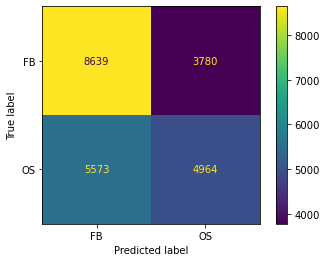

In [1461]:
y_pred = rf_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=rf_pipe.classes_).plot()